# HF Radars & Coastal Altimetry

This notebook is a demonstration of how to read, subset and visualize HF radar data. Specifically, the IOOS HFRADAR US East and Gulf Coast 6km Resolution Hourly RTV dataset. The dataset's THREDDS catalog can be found in the link below:

https://hfrnet-tds.ucsd.edu/thredds/HFRADAR_USEGC.html

The urls have to be modified accordingly to use a different dataset.

Another goal of this notebook is to compare with the geostrophic current velocities estimated from satellite altimeter sea level anomaly data and the CMEMS global analysis. Please note that the global analysis system is not assimilating the US East Coast HF radar observations.

The satellite altimeter dataset used is XTRACK which is dedicated for coastal applications.

https://www.aviso.altimetry.fr/index.php?id=3047

Information about the CMEMS global analysis model can be found here:

https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=GLOBAL_ANALYSIS_FORECAST_PHY_001_024

In [14]:
# import libraries

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import sys
from libr import geost1D, bounds, quiver_comp, loess
#plotting libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
from matplotlib.lines import Line2D

## Select area of interest and cycle

This notebook focuses on the Mid Atlantic bight. The along-track 228 from the Jason 3 (a successor of Topex Poseidon, Jason 1 and 2) cycle 157 was selected but the same process can be followed for any altimeter track from the XTRACK (or other along track datasets).

more details about the Jason 3 mission:

https://www.aviso.altimetry.fr/en/missions/current-missions/jason-3.html

In [2]:
min_lon, max_lon = -76, -73
min_lat, max_lat = 36.5, 39.5
min_cycle, max_cycle = 1019, 1019

## Load the dataset

The XTRACK dataset is publickly available on the AVISO server. The area and cycle of interest can be selected using xarray.

In [4]:
#load file of selected track
loc = "./data/SLAFILT/ctoh.sla.filt.ref.TP+J1+J2+J3.gulfstream.228.nc"
ds = xr.open_dataset(loc)
#assign coordinates
ds = ds.rename({"missions_cycles": "cycles", "cycle":"xtrack_cycle"}).set_coords(["lat", "lon", "cycles"])
#subset by set bounds
point_idx, cycle_idx = bounds(ds.lat.data, 
                              ds.lon.data, 
                              ds.xtrack_cycle.data, 
                              min_lat, 
                              max_lat, 
                              min_lon, 
                              max_lon, 
                              min_cycle, 
                              max_cycle)
ds = ds.isel(nbpoints = point_idx, nbcycles = cycle_idx)
cycle_array = ds.xtrack_cycle.data
#converting JulianTime to datetime (TBC)
#print(ds['time'])
#dt_idx = ds.index["time"].to_datetimeindex()
#ds['time'] = dt_idx

## Calculate across-track geostrophic current velocity

Only the across-track velocities can be calculated using the altimeter SLA values. The XTRACK SLA along-track values are already filtered with 40-km loess filter. The geost1D function is used for the estimation of the geostrophic current velocities.

Credits: Fabien Leger

In [7]:
#initalise array
u_geo = np.nan * ds.sla.data
#run for each cycle
for i in enumerate(cycle_array):
    #select respective data slice
    sel_cycle = ds.isel(nbcycles = i[0])
    sel_point = ds.isel(nbcycles = 0)
    #calculate geostrophic speeds for the cycle (dynamic comp)
    u_geo[:, i[0]] = geost1D(sel_cycle.lon.data, sel_cycle.lat.data, 1, sel_cycle.sla.data)
    #create DataArray for time and sea level anomaly
    time_da = xr.DataArray(data = ds.time.data, 
                           dims = ["loc", "cycle"], 
                           coords = dict(lat = ("loc", ds.lat.data),
                                         lon = ("loc", ds.lon.data), 
                                         cycle = ("cycle", ds.cycles.data.astype('int'))))
    sla_da = xr.DataArray(data = ds.sla.data, 
                          dims = ["loc", "cycle"], 
                          coords = dict(lat = ("loc", ds.lat.data),
                                        lon = ("loc", ds.lon.data), 
                                        cycle = ("cycle", ds.cycles.data.astype('int'))))
#convert to DataArray
u_geo = xr.DataArray(data = u_geo, dims = ["loc", "cycle"], 
                     coords = dict(lat = ("loc", ds.lat.data),
                                   lon = ("loc", ds.lon.data),
                                   cycle = ("cycle", ds.cycles.data.astype('int'))))
#calculate mean geostrophic speeds (mean comp) and convert to DataArray
u_mean = geost1D(sel_point.lon.data, sel_point.lat.data, 1, sel_point.mdt_cnes_cls_18.data)
u_mean = xr.DataArray(data = u_mean, dims = ["loc"], coords = dict(lat = ("loc", ds.lat.data),
                                                                  lon = ("loc", ds.lon.data)))
#calculate total geostrophic speed
u_total = u_geo + u_mean

#calculate zonal and meridional component
x_comp = np.nan * ds.sla.data
y_comp = np.nan * ds.sla.data
v_angle = np.nan * ds.sla.data
for i in enumerate(cycle_array):
    u_total_sel = u_total.isel(cycle = i[0])
    x_comp[:, i[0]], y_comp[:, i[0]], v_angle[:, i[0]], _ = quiver_comp(u_total_sel.data, 
                                                                        u_total_sel.lat.data, 
                                                                        u_total_sel.lon.data)
x_comp = xr.DataArray(data = x_comp, 
                      dims = ["loc", "cycle"], 
                      coords = dict(lat = ("loc", ds.lat.data),
                                    lon = ("loc", ds.lon.data),
                                    cycle = ("cycle", ds.cycles.data.astype('int'))))
y_comp = xr.DataArray(data = x_comp, 
                      dims = ["loc", "cycle"], 
                      coords = dict(lat = ("loc", ds.lat.data),
                                    lon = ("loc", ds.lon.data),
                                    cycle = ("cycle", ds.cycles.data.astype('int'))))
v_angle = xr.DataArray(data = v_angle, 
                       dims = ["loc", "cycle"], 
                       coords = dict(lat = ("loc", ds.lat.data), 
                                     lon = ("loc", ds.lon.data), 
                                     cycle = ("cycle", ds.cycles.data.astype('int'))))

In [9]:
#create a dataset
geostrophic = xr.Dataset(data_vars = {"u_total": u_total, "u_geo": u_geo, "time": time_da, 
                                      "u_mean": u_mean, "x_comp": x_comp, "y_comp": y_comp,
                                      "current_angle": v_angle, "sla": sla_da})

## Save the file

In [20]:
geostrophic.to_netcdf("./data/alt_ugeo.nc")

## Download HFR data to compare with alongtrack altimetry

In [10]:
#open dataset
hfr_ds = xr.open_dataset("./data/hf_radar_05_2020.nc")
#select nearest time option
hfr_ds = hfr_ds.sel(time = "2020-05-22T04:00:00")

## Download CMEMS reanalysis

In [12]:
#open dataset
cmems_ds = xr.open_dataset("./data/CMEMS-global-analysis-forecast-phy-001-024-hourly-u-v.nc")
cmems_ds = cmems_ds.rename({"latitude": "lat", "longitude": "lon"})
#select nearest time option
cmems_ds = cmems_ds.sel(time = "2020-05-22T03:30:00")

## Visualize

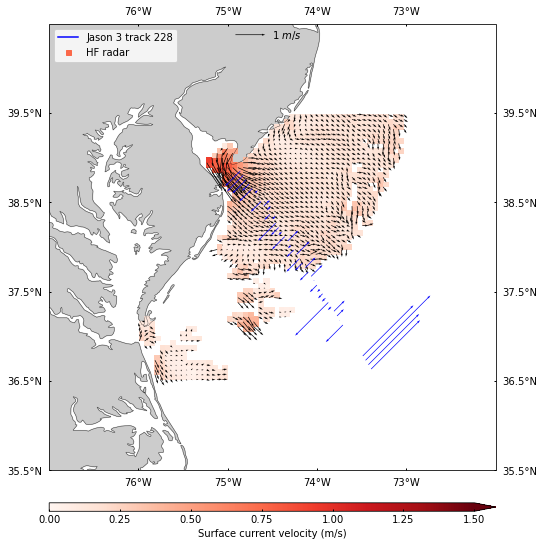

In [15]:
#ruthlessly copying Panagiotis's code
##only suitable for a single (!) cycle
fig = plt.figure(figsize=(8,12))
proj = ccrs.PlateCarree()
ax=fig.add_subplot(1,1,1,projection=proj)
ax.set_extent([min_lon-1, max_lon+1, min_lat-1, max_lat+1])

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

lon_ticks = np.arange(min_lon, max_lon+1, 1)
lat_ticks = np.arange(min_lat-1, max_lat+1, 1)

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax.xaxis.set_tick_params(which='major', size=2., width=1, direction='in', top='on', pad=7)
ax.yaxis.set_tick_params(which='major', size=2., width=1, direction='in', right='on',pad=7)

ax.tick_params(labelleft=True,labelbottom=True,labeltop=True,labelright=True)  

ax.add_feature(cfeature.LAND.with_scale('10m'), color='grey', alpha=0.4)

ax.coastlines(resolution='10m',linewidth=0.3)

bounds = np.array([0.,0.25,0.5,0.75,1.,1.25,1.5])

xi, yi = np.meshgrid(hfr_ds.lon.data, hfr_ds.lat.data)
m = np.sqrt(hfr_ds.u.data*hfr_ds.u.data + hfr_ds.v.data*hfr_ds.v.data)

# hf radar 
cp = ax.pcolor(xi, yi, m, cmap = plt.cm.Reds, label='HF radar',vmin=0., vmax=1.5)

# add the vectors (hf radar, altimetry) and the scale for the geostrophic currents magnitude

cf = ax.quiver(xi,yi,hfr_ds.u,hfr_ds.v,color='black',scale=15,width=.0015)
ax.quiver(geostrophic.lon.data, geostrophic.lat.data, x_comp.data, y_comp.data,scale=15,width=.0015, color='blue',
              label='Jason 3 track 228')

qk = ax.quiverkey(cf, 0.5, 0.78, 1., label='$1 \ m/s$', labelpos='E',
                   coordinates='figure')

cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cp, cax=cax, ticks=bounds,extend='max',**kw)
out.set_label('Surface current velocity (m/s)',size=10)
out.ax.tick_params(direction='in',size=2., width=1)

cmap = plt.cm.Reds
hfradar = Line2D([0], [0], marker='s', color='white', linestyle="", label='HF radar',
                          markerfacecolor=cmap(0.5),markeredgecolor=cmap(0.5), markersize=5)
altimeter = Line2D([0], [0], marker='', markersize=5, color='blue', linestyle="-", label='Jason 3 track 228', markeredgecolor='blue', 
              markeredgewidth=0.5)
                  
ax.legend(handles=[altimeter,hfradar], loc='upper left',fontsize=10, facecolor='white')

plt.savefig('./img/alt_hfr.png', dpi=300, transparent=False, bbox_inches='tight')

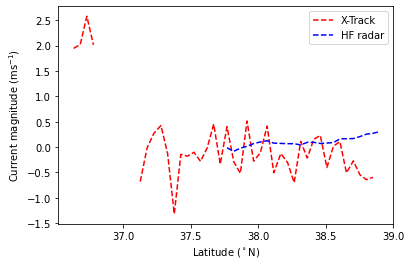

In [24]:
interp_method = 'nearest'
plot_xaxis_altimeter = geostrophic.lat.data
plot_yaxis_altimeter = geostrophic.u_total.data
plot_xaxis_hfr = hfr_ds.lat.interp(lat = geostrophic.lat)
U_hfr = np.sqrt(hfr_ds.u.interp(lat = geostrophic.lat, lon = geostrophic.lon, method = interp_method)*
                         hfr_ds.u.interp(lat = geostrophic.lat, lon = geostrophic.lon, method = interp_method) + 
                         hfr_ds.v.interp(lat = geostrophic.lat, lon = geostrophic.lon, method = interp_method)*
                         hfr_ds.v.interp(lat = geostrophic.lat, lon = geostrophic.lon, method = interp_method))
A_hfr = np.arctan2(hfr_ds.v.interp(lat = geostrophic.lat, lon = geostrophic.lon, method = interp_method),
                  hfr_ds.u.interp(lat = geostrophic.lat, lon = geostrophic.lon, method = interp_method))
plot_yaxis_hfr = U_hfr * np.cos(A_hfr - geostrophic.current_angle)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(plot_xaxis_altimeter, plot_yaxis_altimeter, 'r--', label = 'X-Track')
ax.plot(plot_xaxis_hfr, plot_yaxis_hfr, 'b--', label = 'HF radar')
ax.set_xlabel('Latitude ($^\circ$N)')
ax.set_ylabel(r'Current magnitude (ms$^{-1}$)')
ax.legend(loc = 'best')
plt.savefig("./img/alt_hfr_lineplot.png")

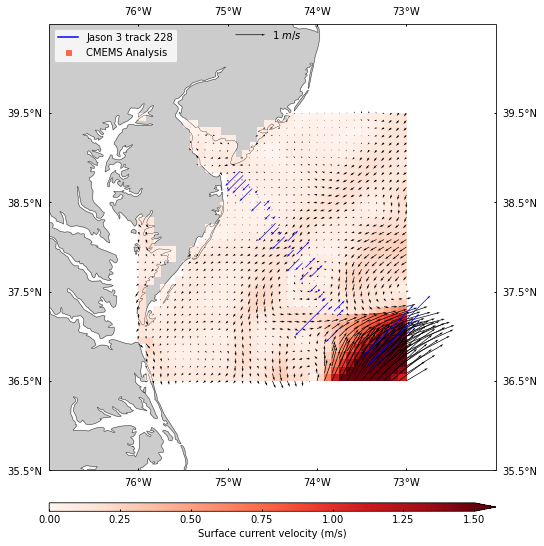

In [16]:
fig = plt.figure(figsize=(8,12))
proj = ccrs.PlateCarree()
ax=fig.add_subplot(1,1,1,projection=proj)
ax.set_extent([min_lon-1, max_lon+1, min_lat-1, max_lat+1])

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

lon_ticks = np.arange(min_lon, max_lon+1, 1)
lat_ticks = np.arange(min_lat-1, max_lat+1, 1)

ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

ax.xaxis.set_tick_params(which='major', size=2., width=1, direction='in', top='on', pad=7)
ax.yaxis.set_tick_params(which='major', size=2., width=1, direction='in', right='on',pad=7)

ax.tick_params(labelleft=True,labelbottom=True,labeltop=True,labelright=True)  

ax.add_feature(cfeature.LAND.with_scale('10m'), color='grey', alpha=0.4)

ax.coastlines(resolution='10m',linewidth=0.3)
bounds = np.array([0.,0.25,0.5,0.75,1.,1.25,1.5])
norm = mpl.colors.Normalize(vmin=0., vmax=1.5)

xi, yi = np.meshgrid(cmems_ds.lon.data, cmems_ds.lat.data)
m = np.sqrt(cmems_ds.uo.data*cmems_ds.uo.data + cmems_ds.vo.data*cmems_ds.vo.data)[0,:,:]
cp = ax.pcolor(xi, yi, m, cmap = plt.cm.Reds,vmin=0., vmax=1.5)

cf = ax.quiver(xi,yi,cmems_ds.uo[0,:,:],cmems_ds.vo[0,:,:],color='black',scale=15,width=.0015)
ax.quiver(geostrophic.lon.data, geostrophic.lat.data, x_comp.data, y_comp.data,scale=15,width=.0015, color='blue',
              label='Jason 3 track 228')

qk = ax.quiverkey(cf, 0.5, 0.78, 1., label='$1 \ m/s$', labelpos='E',
                   coordinates='figure')

cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)

out=fig.colorbar(cp,cax=cax,ticks=bounds,extend='max',**kw)
out.set_label('Surface current velocity (m/s)',size=10)
out.ax.tick_params(direction='in',size=2., width=1)

cmap = plt.cm.Reds
analysis = Line2D([0], [0], marker='s', color='white', linestyle="", label='CMEMS Analysis',
                          markerfacecolor=cmap(0.5),markeredgecolor=cmap(0.5), markersize=5)
altimeter = Line2D([0], [0], marker='', markersize=5, color='blue', linestyle="-", label='Jason 3 track 228', markeredgecolor='blue', 
              markeredgewidth=0.5)
                  
ax.legend(handles=[altimeter,analysis], loc='upper left',fontsize=10, facecolor='white')

plt.savefig('./img/alt_cmems.png', dpi=300, transparent=False, bbox_inches='tight')